In [29]:
import numpy as np


def softmax(logits):
    """softmax function with normalization"""
    # Normalize logits for numerical stability
    normalized_logits = logits - np.max(logits)
    exp_logits = np.exp(normalized_logits)
    return exp_logits / np.sum(exp_logits)
def softmax_grad(s):
    jacobian_m = np.diag(s)
    for i in range(len(jacobian_m)):
        for j in range(len(jacobian_m)):
            if i == j:
                jacobian_m[i][j] = s[i] * (1-s[i])
            else:
                jacobian_m[i][j] = -s[i] * s[j]
    return jacobian_m
def policy(state, weight):
    """simple policy function"""
    # flatten the state with the weight
    logits = np.dot(state, weight)
    action_probs = softmax(logits)
    if np.isnan(action_probs).any():
        return np.ones_like(action_probs) / len(action_probs)
    return action_probs

def policy_gradient(state, weight):
    logits = np.dot(state, weight)
    action_probs = softmax(logits)
    action = np.random.choice(len(action_probs), p=action_probs)
    if np.isnan(action_probs).any():
        return np.ones_like(action_probs) / len(action_probs)
    grad_log_probs = np.outer(state, (action_probs - (action == np.arange(len(action_probs)))))

    return action, grad_log_probs



In [30]:
def xavier_init(shape):
    """Xavier initialization for weights"""
    fan_in = shape[0]
    fan_out = shape[1]
    stddev = np.sqrt(2.0 / (fan_in + fan_out))
    return np.random.normal(0, stddev, shape)
def he_init(shape):
    """He initialization for weights"""
    fan_in = shape[0]
    stddev = np.sqrt(2.0 / fan_in)
    return np.random.normal(0, stddev, shape)

In [31]:
import tqdm
import imageio
import IPython.display as display
import time

def train(env, nb_episodes, alpha=0.000045, gamma=0.98, epsilon=0.1, show_result=False, initial=he_init):
    """Training function"""
    # Initialize the weight
    weight = initial((env.observation_space.shape[0], env.action_space.n))
    mean_state = np.zeros(env.observation_space.shape[0])
    std_state = np.ones(env.observation_space.shape[0])
    scores = []

    for ep in tqdm.tqdm(range(nb_episodes)):
        state ,_= env.reset()
        episode = []
        grads = []
        episode_score = 0

        while True:
            n_state = (state - mean_state) / std_state

            # Epsilon-greedy exploration
            if np.random.rand() < epsilon:
                action = np.random.choice(env.action_space.n)
                if np.isnan(action).any():
                    action = np.ones_like(action) / len(action)
                _, grad = policy_gradient(n_state, weight)
            else:
                action, grad = policy_gradient(n_state, weight)
                if np.isnan(action).any():
                    action = np.ones_like(action) / len(action)
                action_probs = policy(state, weight)
                if np.isnan(action_probs).any():
                    action = np.ones_like(action_probs) / len(action_probs)

            next_state, reward, done, _,_ = env.step(action)
            episode.append((state, action, reward))
            grads.append(grad)
            episode_score += reward

            state = next_state
            if done:
                break

        states = np.array([step[0] for step in episode])
        mean_state = np.mean(states, axis=0)
        std_state = np.std(states, axis=0)

        if show_result and (ep + 1) % 1000 == 0:
            env.render()
            st, _= env.reset()
            img = env.render()
            imgs = []

            while True:
                action, _ = policy_gradient(st, weight)
                state, reward, done, _,_ = env.step(action)
                img = env.render()
                imgs.append(img)
                if done:
                    break

            gif_path = f'gif/cartpole{ep + 1}.gif'
            imageio.mimsave(gif_path, [np.array(img) for i, img in enumerate(imgs)], fps=1000)
            display.display(display.Image(filename=gif_path))
            time.sleep(1.5)  # Display the GIF for 2 seconds
            display.clear_output(wait=True)  # Clear the output after displaying the GIF
            env.close()

        scores.append(episode_score)

        Gt = 0
        for i in range(len(episode)):
            Gt = sum([gamma ** (j - i) * episode[j][2] for j in range(i, len(episode))])
            step, action, _ = episode[i]
            action_probs = policy(step, weight)
            if np.isnan(action_probs).any():
                action = np.ones_like(action_probs) / len(action_probs)
            Ln = np.log(action_probs[action])
            weight += alpha * Gt * Ln * grads[i]

    return scores, weight


100%|██████████| 11308/11308 [00:47<00:00, 238.72it/s]


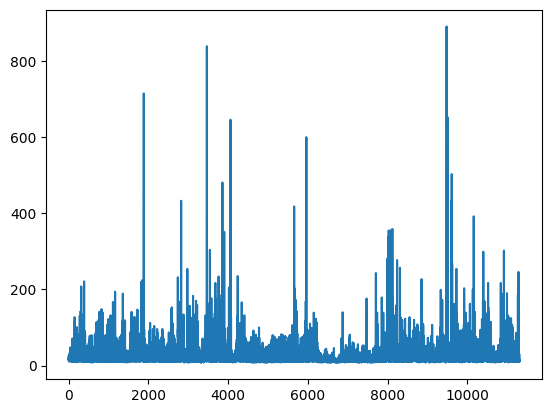

In [34]:
import gym
import matplotlib.pyplot as plt
import numpy as np

env = gym.make('CartPole-v1' , render_mode='rgb_array' )
scores = None
weight = None
scores ,weight = train(env, nb_episodes=11308,alpha=0.000918596381287814,gamma=0.9850142133864869,epsilon=0.0690426934313028, show_result = True)


plt.plot(np.arange(len(scores)), scores)
plt.show()
env.close()

In [33]:
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
import gym

def objective(trial):
    alpha = trial.suggest_float('alpha', 1e-5, 1e-3)
    gamma = trial.suggest_float('gamma', 0.95, 0.999)
    nb_episodes = trial.suggest_int('nb_episodes', 1000, 20000)
    initial = trial.suggest_categorical('initial', [xavier_init, he_init])
    epsilon = trial.suggest_float('epsilon', 0.005, 0.1)

    env = gym.make('CartPole-v1')
    scores = train(env, nb_episodes, alpha, gamma, epsilon, show_result=False, initial=he_init)[0]
    env.close()

    mean_score = np.mean(scores)
    max_score = np.max(scores)

    # Penalize if mean score is below 350 or max score is below 400
    penalty = 0
    if  mean_score < 350 :
        penalty += 500 - mean_score

    return mean_score - penalty

# Adjust the pruning strategy if necessary
pruner = MedianPruner(n_warmup_steps=5)
sampler = TPESampler(seed=10)

study = optuna.create_study(sampler=sampler, pruner=pruner)
study.optimize(objective, n_trials=100)

print("Best trial:")
best_trial = study.best_trial
print("  Value: ", best_trial.value)
print("  Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))


[I 2024-03-06 13:35:54,187] A new study created in memory with name: no-name-50d2c47a-7b5f-4ff7-856f-6638d53aed9c
/home/uoch/tf/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <function xavier_init at 0x7f13782b1d80> which is of type function.
  warnings.warn(message)
/home/uoch/tf/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <function he_init at 0x7f13782b1cf0> which is of type function.
  warnings.warn(message)
100%|██████████| 13039/13039 [00:28<00:00, 450.57it/s]
[I 2024-03-06 13:36:23,131] Trial 0 finished with value: -437.5493519441675 and parameters: {'alpha': 0.0007736074368340785, 'gamma': 0.9510168455186107, 'nb_episodes': 13039, 'initial': <function xavier_init at 0x7f13782b1d8

ValueError: probabilities contain NaN

In [44]:
import gym
import imageio
env = gym.make('CartPole-v1' , render_mode = "rgb_array")  # Create the environment

# Render the environment
st ,_= env.reset()
action = 1
img = env.render()
images = []
print(weit.shape)
print(st.shape)
while True:
    action = np.argmax(policy(st, weit))
    st, reward, done, _ ,_= env.step(action)
    img = env.render()
    images.append(img)
    if done:
        break
imageio.mimsave('cartpole.gif', [np.array(img) for i, img in enumerate(images) ], fps=1000)


env.close()  # Close the environment after rendering


(4, 2)
(4,)
32
